In [1]:
import pickle

with open("../model_arthur/data/data_useable.pickle", "rb") as f:
    train_images, train_labels = pickle.load(f)

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7.6618915..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.19699204..254.77048].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.44003].
Clipping input data to the valid range fo

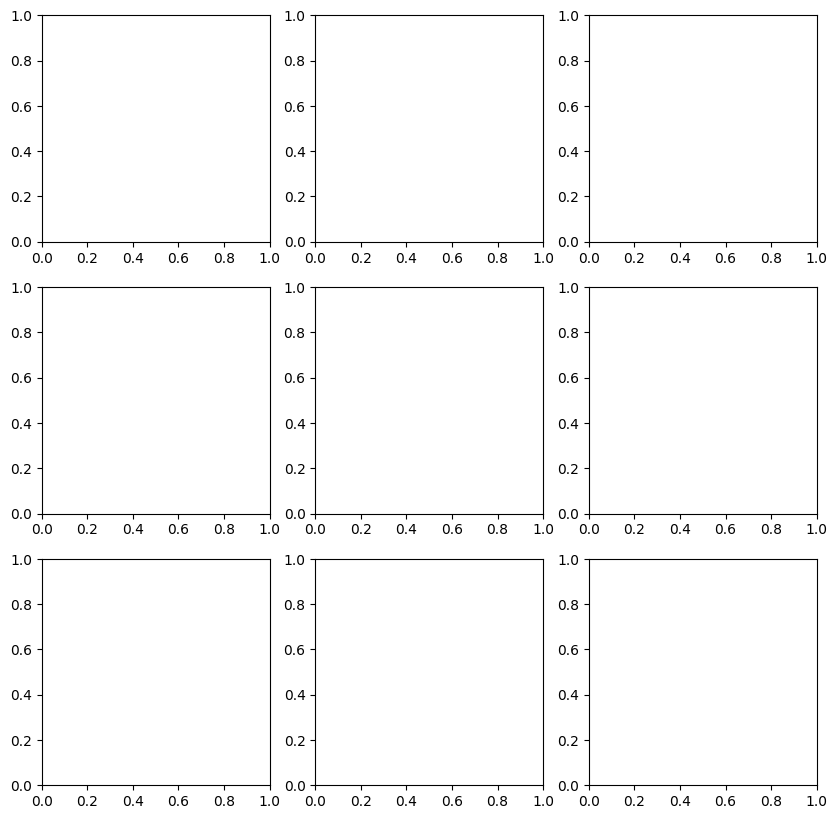

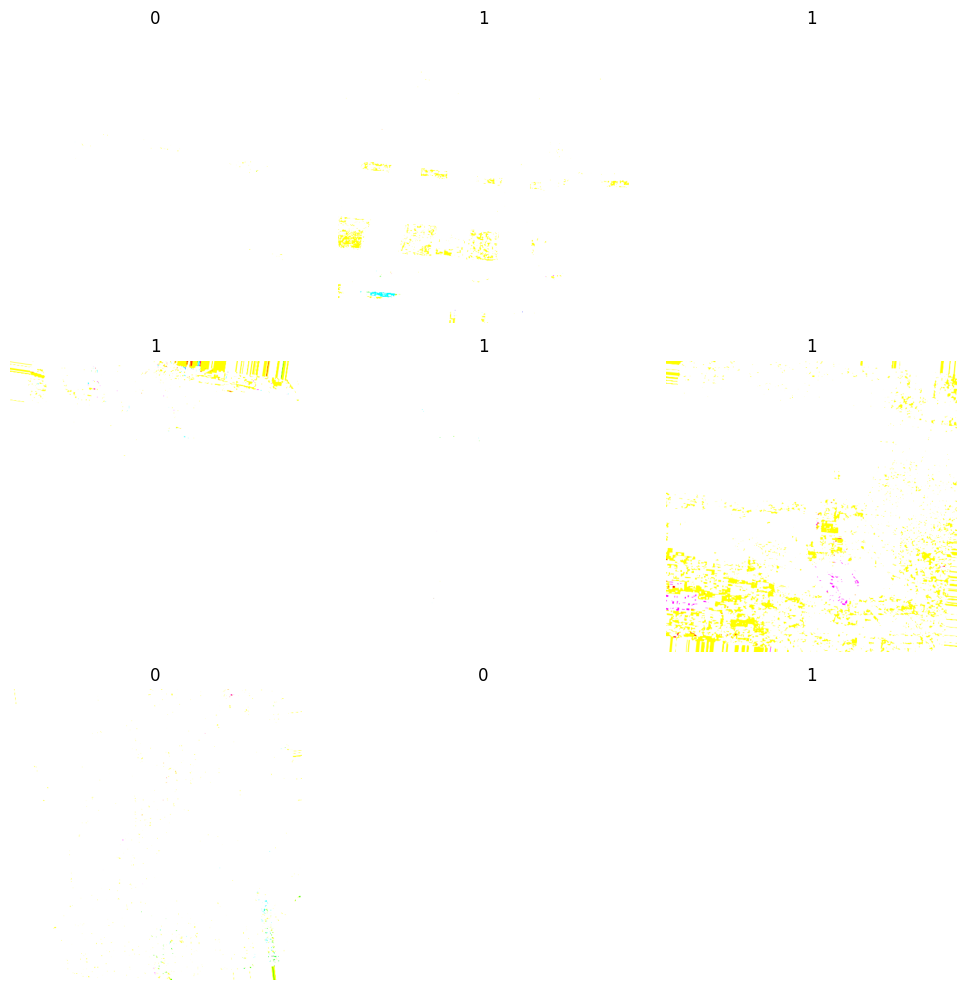

In [3]:
import matplotlib.pyplot as plt
import numpy as np


X_train_image = train_images.astype(np.float32)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
  idx = np.random.randint(X_train_image.shape[0])
  ax.imshow(X_train_image[idx])
  ax.set_title(str(train_labels[idx]))
  ax.axis('off')
plt.tight_layout()
plt.show()


In [2]:
train_images.shape, train_labels.shape

((2000, 512, 512, 3), (2000,))

In [6]:
import os
os.environ['TF_ENABLE_MKL'] = '1'

In [18]:
import tensorflow as tf
import numpy as np
from keras.utils import to_categorical


augmented_images = np.array(train_images, dtype=np.float32)
augmented_labels = np.array(train_labels, dtype=np.int32)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

In [19]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1600, 512, 512, 3), (1600, 2), (400, 512, 512, 3), (400, 2))

In [8]:
# Create TensorFlow datasets
batch_size = 2

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Normalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

base_model = MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Set every second BatchNormalization layer to not trainable
batch_norm_counter = 0
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        batch_norm_counter += 1
        if batch_norm_counter % 2 == 0:
            layer.trainable = False

x = base_model.output
x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Normalization()(x)

x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Normalization()(x)
x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

/var/folders/dx/_wrb0x2x55s3j5yr_z1w2fbw0000gn/T/ipykernel_2387/727635611.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(
  X_train,
  y_train, 
  epochs=10, 
  batch_size=2,
  validation_data=(X_val, y_val)
  )

Epoch 1/10


AttributeError: 'NoneType' object has no attribute 'items'

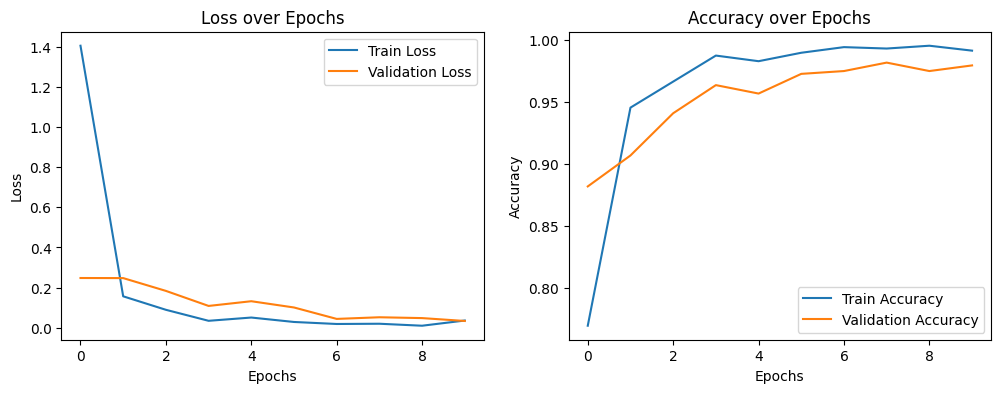

In [8]:
# Optionally, plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

In [9]:
model.save('../models/pre_model_6_1.h5')